# 데이터 로드

In [7]:
import pandas as pd
import numpy as np
# 데이터 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 상위 5개 데이터 확인
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


# EDA - 데이터 분석

## 내부항 살펴보기

In [11]:
from ydata_profiling import ProfileReport

profile_master = ProfileReport(
    train,
    title="Titanic Profiling",
    explorative=True
)

profile_master

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


# 데이터 전처리

In [19]:
def titanic_preprocessing(df):
    df = df.copy()
    df['AgeBand'] = pd.cut(df['Age'].fillna(df['Age'].median()), bins=[0, 16, 55, 100], labels=['Child', 'Adult', 'Senior'], right=False) # 나이 3분할 (당시 청소년 나이와 노년 나이 판단)
    df['FareBand'] = pd.qcut(df['Fare'], 4, labels=['Low', 'Mid', 'High', 'Vip'])                                                         # 운임은 4분할
    df['SibSpY'] = pd.cut(df['SibSp'].fillna(df['SibSp'].median()), bins=[0, 1, 20], labels=['Alone', 'Withmate'], right=False)                 # 배우자가 있는가 없는가로 구분
    df['ParchY'] = pd.cut(df['Parch'].fillna(df['Parch'].median()), bins=[0, 1, 20], labels=['Alone', 'WithFamily'], right=False)                # 가족이 있는가 없는가로 구분
    return df[['Pclass', 'SibSpY', 'ParchY', 'Sex', 'AgeBand', 'FareBand', 'Embarked']]                      # PassengerId, Name는 unique, Ticket도 고유값이 많고, Cabin은 missing이 많아 drop

## 파이프라인 구성

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_features = ['Pclass']     # 수치형 데이터 (스케일링 적용)
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_features = ['Sex', 'AgeBand', 'FareBand', 'Embarked', 'SibSpY', 'ParchY']     # 범주형 데이터 OHE
cat_transformer = Pipeline(steps=[
('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

processed_df = titanic_preprocessing(train)
final_features = preprocessor.fit_transform(processed_df)

print("전처리된 데이터 컬럼 개수:", final_features.shape[1])
print("샘플 데이터 (첫 번째 행):\n", final_features[0])

전처리된 데이터 컬럼 개수: 18
샘플 데이터 (첫 번째 행):
 [0.82737724 0.         1.         1.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         0.         0.         1.         1.         0.        ]


# 데이터 예측 (선형회귀, 비선형회귀 비교)

In [23]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

y = train['Survived']

models = [
    ('LogiReg', LogisticRegression()),
    ('Lin-SVM', SVC(kernel='linear')),
    ('Dec-Tree', DecisionTreeClassifier()),
    ('Ran-Forest', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier())
]

print("=== 모델별 평균 정확도(Accuracy) 비교 ===")

for name, model in models:     # 5겹 교차 검증 (데이터를 5번 나눠서 테스트)
    scores = cross_val_score(model, final_features, y, cv=5)
    print(f"{name}: {scores.mean():.4f}")

=== 모델별 평균 정확도(Accuracy) 비교 ===
LogiReg: 0.7834
Lin-SVM: 0.7867
Dec-Tree: 0.8104
Ran-Forest: 0.8160
KNN: 0.8126


## 데이터 영향 주는 요소 비교

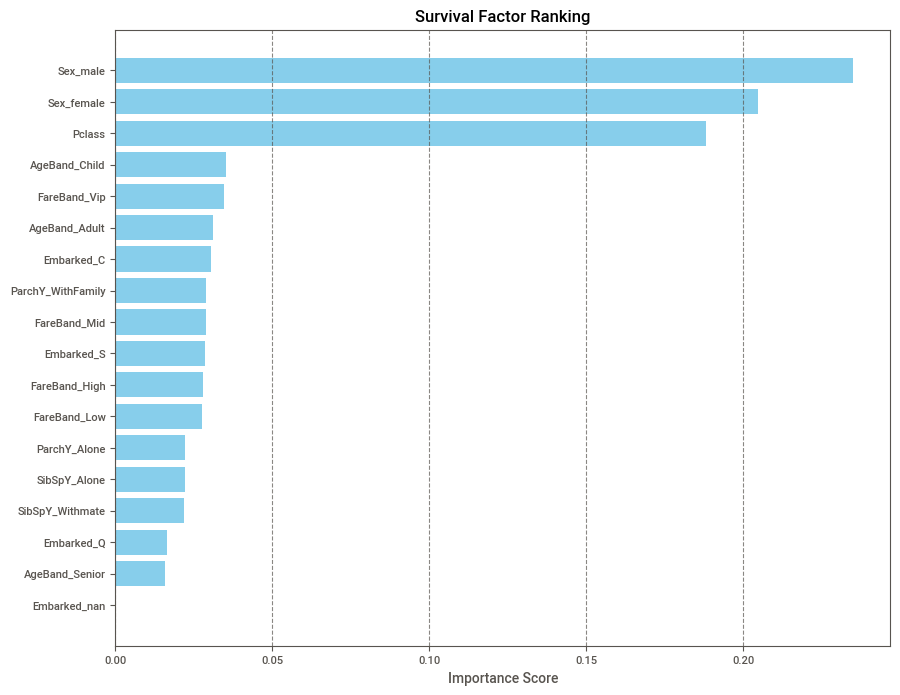

In [24]:
import matplotlib.pyplot as plt
import numpy as np

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(final_features, y)

cat_encoder = preprocessor.named_transformers_['cat']['onehot']
ohe_cols = cat_encoder.get_feature_names_out(cat_features)
all_cols = num_features + list(ohe_cols)

importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title('Survival Factor Ranking')
plt.barh(range(len(indices)), importances[indices], align='center', color='skyblue')
plt.yticks(range(len(indices)), [all_cols[i] for i in indices])
plt.xlabel('Importance Score')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [32]:
import warnings
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')

num_features = ['Pclass']
cat_features = ['Sex', 'AgeBand', 'FareBand', 'Embarked', 'SibSpY', 'ParchY']

preprocessor = ColumnTransformer(
transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
])

final_features = preprocessor.fit_transform(processed_df)

models = [
    ('Ran-Forest', RandomForestClassifier(random_state=42)),
    ('LightGBM', LGBMClassifier(verbose=-1, random_state=42)),
    ('XGBoost', XGBClassifier(eval_metric='logloss', random_state=42)),
    ('CatBoost', CatBoostClassifier(verbose=0, random_state=42))
]

print("=== 최종 모델 성능 비교 (Pclass: 수치형 유지) ===")

for name, model in models:
    scores = cross_val_score(model, final_features, y, cv=5)   # 5겹 교차 검증
    print(f"{name}: {scores.mean():.4f}")

=== 최종 모델 성능 비교 (Pclass: 수치형 유지) ===
Ran-Forest: 0.8137
LightGBM: 0.8272
XGBoost: 0.8171
CatBoost: 0.8104


# 제출

In [33]:
warnings.filterwarnings('ignore')
test = pd.read_csv('test.csv')

processed_test = titanic_preprocessing(test)

final_test_features = preprocessor.transform(processed_test)

final_lgbm = LGBMClassifier(verbose=-1, random_state=42)
final_lgbm.fit(final_features, y)
predictions = final_lgbm.predict(final_test_features)

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": predictions
})

submission.to_csv('submission.csv', index=False)

## 추가 튜닝

In [5]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['Title'] = train.Name.str.extract(' ([A-Za-z]+).', expand=False)
train['Title'] = train['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train['Title'] = train['Title'].replace(['Mlle', 'Ms'], 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')
train['Age'] = train['Age'].fillna(train['Age'].median())
train['Fare'] = train['Fare'].fillna(train['Fare'].median())
train['Embarked'] = train['Embarked'].fillna('S')

test['Title'] = test.Name.str.extract(' ([A-Za-z]+).', expand=False)
test['Title'] = test['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test['Title'] = test['Title'].replace(['Mlle', 'Ms'], 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')
test['Age'] = test['Age'].fillna(test['Age'].median())
test['Fare'] = test['Fare'].fillna(test['Fare'].median())
test['Embarked'] = test['Embarked'].fillna('S')

features_to_encode = ['Sex', 'Title', 'Embarked']
for feature in features_to_encode:
    le = LabelEncoder()
    le.fit(list(train[feature].values) + list(test[feature].values))  # Train과 Test의 범주를 합쳐서 인코딩 기준을 맞춥니다.
    train[feature] = le.transform(train[feature])
    test[feature] = le.transform(test[feature])

features = ['Pclass', 'Sex', 'Title', 'Embarked', 'Age', 'Fare', 'SibSp', 'Parch']
X_train = train[features]
y_train = train['Survived']

model_params = {
    'SVM': {
        'model': SVC(kernel='linear', random_state=42),
        'params': {'C': [0.1, 1, 10]}
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(verbose=-1, random_state=42),
        'params': {
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 4, 5]
        }
    }
}

scores = []
print("=== 최적화 진행 중 (잠시만 기다려주세요) ===")

for model_name, mp in model_params.items():
    grid = GridSearchCV(mp['model'], mp['params'], cv=5)
    grid.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_
    })
    print(f"{model_name} 최적화 완료!")

print("\n=== 최종 비교 결과 ===")
for result in scores:
    print(f"모델: {result['model']}")
    print(f"최적 검증 점수: {result['best_score']:.4f}")
    print(f"최적 파라미터: {result['best_params']}")
    print("-" * 30)

=== 최적화 진행 중 (잠시만 기다려주세요) ===
SVM 최적화 완료!
RandomForest 최적화 완료!
LightGBM 최적화 완료!

=== 최종 비교 결과 ===
모델: SVM
최적 검증 점수: 0.7879
최적 파라미터: {'C': 0.1}
------------------------------
모델: RandomForest
최적 검증 점수: 0.8238
최적 파라미터: {'max_depth': 7, 'n_estimators': 200}
------------------------------
모델: LightGBM
최적 검증 점수: 0.8395
최적 파라미터: {'learning_rate': 0.1, 'max_depth': 5}
------------------------------


In [9]:
best_model_name = ""
max_score = 0
final_model = None

for result in scores:
    if result['best_score'] > max_score:
        max_score = result['best_score']
        best_model_name = result['model']

print(f"최종 우승 모델: {best_model_name} (점수: {max_score:.4f})")

for model_name, mp in model_params.items():
    if model_name == best_model_name:
        grid = GridSearchCV(mp['model'], mp['params'], cv=5)
        grid.fit(X_train, y_train)
        final_model = grid.best_estimator_

X_test = test[features]
final_predictions = final_model.predict(X_test)

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": final_predictions
})

submission.to_csv('submission_final.csv', index=False)

최종 우승 모델: LightGBM (점수: 0.8395)
